In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

The thermal conductivity equation:
$\frac{\partial T}{\partial t} - \frac{{\partial}^2 T}{\partial x^2} = 0$

Assume $ T(t, x) = 2 + e^{-4 \pi^2 t} sin(2\pi x) + e^{-16\pi^2 t} cos(4\pi x)$, $x\in[0,1], t\in[0, 0.05]$
$\\$Boundary condition $T_0 = T(0, x) = 2 + sin(2\pi x) + cos(4\pi x)$

In [11]:
#define amount of sample points
N = 2000

In [12]:
def f_real(t, x):
    return (2 + torch.exp(-4*(torch.pi**2)*t)*torch.sin(2*torch.pi*x) + torch.exp(-16*(torch.pi**2)*t)*torch.cos(4*torch.pi*x))

In [13]:
#define the class PINN
class PINN(nn.Module):
    def __init__(self,input_layer=2,h1=64,h2=64,h3=64,output_layer=1):
        super().__init__()
        self.fc1 = nn.Linear(input_layer,h1)
        self.fc2 = nn.Linear(h1,h2)
        self.fc3 = nn.Linear(h2,h3)
        self.fc4 = nn.Linear(h3,output_layer)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = F.gelu(self.fc2(x))
        x = F.gelu(self.fc3(x))
        x = F.gelu(self.fc4(x))
        
        return x

In [14]:
torch.manual_seed(123)

In [15]:
# pinn = PINN()
# optimizer = torch.optim.SGD(pinn.parameters(), lr=0.3) 

In [16]:
# x_phys = torch.rand(N).view(-1,1)
# t_phys = 0.05 * torch.rand(N).view(-1,1)

Loss1 = $\frac{1}{N} \sum_{i=1}^{N}(T(t_i, x_i)- f_{PINN}(t_i, x_i))^2$

Loss2 = $\frac{1}{N} \sum_{i=1}^{N}(T_0(x_i)- f_{PINN}(0, x_i))^2$

Loss3 = $\frac{1}{N} \sum_{i=1}^{N}(\frac{\partial}{\partial t}f_{PINN}(t_i, x_i) - \frac{{\partial}^2 }{\partial x^2}f_{PINN}(t_i, x_i))^2$

In [21]:
x_phys = torch.rand(N).view(-1,1).requires_grad_(True)
t_ = 0.05 * torch.rand(N).view(-1,1)
t_phys = t_.requires_grad_(True)
points = torch.stack((t_phys,x_phys), -1)
points_bc = torch.stack((torch.zeros(N,1), x_phys), -1)

In [26]:
pinn = PINN()
optimizer = torch.optim.SGD(pinn.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.7)

In [27]:
"""
Neural network training using sum of MSE, boundary condition and partial dirivatives.
"""
epochs = 1000
for i in range(epochs):
    network = pinn.forward(points)
    network_bc = pinn.forward(points_bc)
    
    loss1 = torch.mean((f_real(t_phys, x_phys) - network)**2)
    loss2 = torch.mean((f_real(torch.zeros_like(x_phys), x_phys) - network_bc)**2)
    
    #compute loss using derivatives
    dt = torch.autograd.grad(network, t_phys, torch.ones_like(network), create_graph=True)[0]
    dx = torch.autograd.grad(network, x_phys, torch.ones_like(network), create_graph=True)[0]
    dx2 = torch.autograd.grad(dx, x_phys, torch.ones_like(dx), create_graph=True)[0]
    loss3 = torch.mean((dt - dx2)**2)
    
    loss = loss2 + loss3 + loss1
    loss.backward()
    
    optimizer.step()
    scheduler.step(loss)
    if i % 100 == 0:
        print(f'epoch: {i}\tamount of loss: {loss}\t')#learning rate: {scheduler.get_last_lr()}')

epoch: 0	amount of loss: 8.958152770996094	
epoch: 100	amount of loss: 1.6436342000961304	
epoch: 200	amount of loss: 1.1795262098312378	


KeyboardInterrupt: 

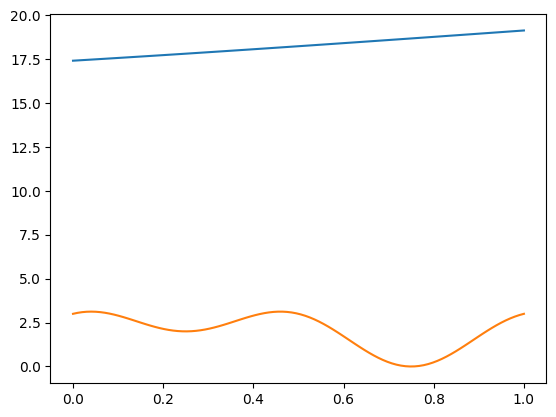

In [11]:
xs = torch.linspace(0, 1, 100)
ts = torch.zeros(100)
graph_points = torch.stack((ts, xs), axis=-1)
#print(graph_points)
T_nn = pinn.forward(graph_points).view(100)
plt.plot(xs.numpy(), T_nn.detach().numpy())
T_real = f_real(ts, xs).view(100)
plt.plot(xs.numpy(), T_real.numpy())

plt.plot()
plt.show()

In [36]:
print(loss)

tensor(1.3737, grad_fn=<AddBackward0>)


In [37]:
x_phys = torch.rand(N).view(-1,1)
print(x_phys[0:10].requires_grad_(True))


tensor([[0.9725],
        [0.7365],
        [0.7152],
        [0.1513],
        [0.9512],
        [0.4517],
        [0.2135],
        [0.7595],
        [0.5913],
        [0.4653]], requires_grad=True)


In [41]:
print(T_real, T_nn)

tensor([3.0000e+00, 3.0554e+00, 3.0945e+00, 3.1176e+00, 3.1250e+00, 3.1173e+00,
        3.0954e+00, 3.0603e+00, 3.0134e+00, 2.9561e+00, 2.8898e+00, 2.8164e+00,
        2.7377e+00, 2.6553e+00, 2.5713e+00, 2.4875e+00, 2.4057e+00, 2.3275e+00,
        2.2548e+00, 2.1889e+00, 2.1312e+00, 2.0830e+00, 2.0451e+00, 2.0184e+00,
        2.0034e+00, 2.0004e+00, 2.0094e+00, 2.0303e+00, 2.0627e+00, 2.1059e+00,
        2.1589e+00, 2.2209e+00, 2.2904e+00, 2.3660e+00, 2.4462e+00, 2.5293e+00,
        2.6134e+00, 2.6968e+00, 2.7776e+00, 2.8539e+00, 2.9239e+00, 2.9859e+00,
        3.0383e+00, 3.0794e+00, 3.1081e+00, 3.1230e+00, 3.1232e+00, 3.1081e+00,
        3.0770e+00, 3.0297e+00, 2.9663e+00, 2.8869e+00, 2.7921e+00, 2.6826e+00,
        2.5595e+00, 2.4240e+00, 2.2776e+00, 2.1218e+00, 1.9586e+00, 1.7898e+00,
        1.6176e+00, 1.4441e+00, 1.2714e+00, 1.1019e+00, 9.3776e-01, 7.8108e-01,
        6.3398e-01, 4.9840e-01, 3.7617e-01, 2.6895e-01, 1.7817e-01, 1.0509e-01,
        5.0685e-02, 1.5706e-02, 6.2931e-